# 🤖 Modèle 3: BERT Fine-tuning - ENTRAÎNEMENT RÉEL
## Restaurant Review Analysis - Transformer avec Hugging Face

**Auteur:** RAHOLDINA FIARA Anjara Mihavana  
**Niveau:** M1 S8  
**Matricule:** 55/M1

## 1. Vérification GPU

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"✅ GPU DISPONIBLE: {torch.cuda.get_device_name(0)}")
    print(f"   Mémoire: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    device = torch.device('cpu')
    print("❌ GPU NON DISPONIBLE!")
    print("⚠️  BERT NÉCESSITE UN GPU - Activez-le maintenant!")
    print("   Runtime → Change runtime type → GPU → T4")

print(f"\nDevice: {device}")

✅ GPU DISPONIBLE: Tesla T4
   Mémoire: 15.64 GB

Device: cuda


## 2. Installation des Packages

In [2]:
!pip install -q transformers datasets accelerate

print("✅ Transformers installés")

✅ Transformers installés


In [3]:
from google.colab import drive
drive.mount('/content/drive')

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"✅ Imports réussis")
print(f"Device: {device}")

Mounted at /content/drive
✅ Imports réussis
Device: cuda


## 3. Chargement de données

In [20]:
# Charger le dataset
df = pd.read_csv('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/dataset/restaurant_reviews.csv')
print(f"Dataset shape: {df.shape}")

# Preprocessing minimal pour BERT (il gère beaucoup lui-même)
def preprocess_for_bert(text):
    # BERT peut gérer la ponctuation, majuscules, etc.
    # On fait juste un nettoyage minimal
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Créer label (0-4)
df['label'] = df['rating'] - 1

# Utiliser seulement text et label
df_bert = df[['text', 'label']].copy()

df.head()

Dataset shape: (1000, 5)


,review_id,text,aspects,sentiments,rating,label
0,R0001,"Amazing cuisine, the steak was cooked to perfe...","food,service","positive,positive",5,4
1,R0002,Poor cleanliness. The bathroom was disgusting....,"cleanliness,price","negative,positive",3,2
2,R0003,"Wonderful ambiance, perfect for a date night. ...","ambiance,price","positive,negative",3,2
3,R0004,Best salad I've ever had. The flavors were inc...,food,positive,5,4
4,R0005,Outstanding customer service. Our waiter was a...,"service,price","positive,neutral",5,4


## 4. Split Train/Val/Test

In [21]:
# Split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"✅ Train: {len(train_df)}")
print(f"✅ Val:   {len(val_df)}")
print(f"✅ Test:  {len(test_df)}")

✅ Train: 700
✅ Val:   150
✅ Test:  150


## 5. Chargement de BERT et Tokenizer

In [22]:
MODEL_NAME = 'bert-base-uncased'

print(f"📥 Téléchargement de {MODEL_NAME}...")

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,  # 5 classes (1-5 stars)
    problem_type="single_label_classification"
).to(device)

print(f"✅ BERT chargé sur {device}")
print(f"   Paramètres: {sum(p.numel() for p in model.parameters()):,}")

📥 Téléchargement de bert-base-uncased...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


✅ BERT chargé sur cuda
   Paramètres: 109,486,085


## 6. Tokenization

In [23]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

# Convertir en Dataset Hugging Face
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

print(f"✅ Datasets créés")
print(f"   Train samples: {len(train_dataset)}")
print(f"   Val samples:   {len(val_dataset)}")
print(f"   Test samples:  {len(test_dataset)}")

# Tokenize
print("\n🔄 Tokenization en cours...")
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

# Format pour PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Tokenization terminée")

# Vérifier ce qui est dans le dataset
print(f"\n📝 Colonnes disponibles après tokenization:")
print(f"   {train_dataset.column_names}")
print(f"\n📝 Premier sample:")
print(f"   Input IDs shape: {train_dataset[0]['input_ids'].shape}")
print(f"   Attention mask shape: {train_dataset[0]['attention_mask'].shape}")
print(f"   Label: {train_dataset[0]['label']}")

✅ Datasets créés
   Train samples: 700
   Val samples:   150
   Test samples:  150

🔄 Tokenization en cours...


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

✅ Tokenization terminée

📝 Colonnes disponibles après tokenization:
   ['label', 'input_ids', 'token_type_ids', 'attention_mask']

📝 Premier sample:
   Input IDs shape: torch.Size([128])
   Attention mask shape: torch.Size([128])
   Label: 2


## 7. Configuration du Training

In [24]:
# Métriques
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy_score(labels, predictions)
    f1_weighted = f1_score(labels, predictions, average='weighted')
    f1_macro = f1_score(labels, predictions, average='macro')

    return {
        'accuracy': acc,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro
    }

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none',
    save_total_limit=2
)

print("✅ Configuration prête")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


✅ Configuration prête


## 8. ENTRAÎNEMENT BERT

In [25]:
# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

print("="*80)
print("🔥 DÉBUT DU FINE-TUNING BERT")
print("="*80)
print(f"Epochs: 4")
print(f"Batch size: 16")
print(f"Learning rate: 2e-5")
print(f"Device: {device}")
print("="*80)

# ENTRAÎNEMENT RÉEL
train_result = trainer.train()

print("\n" + "="*80)
print("🎉 ENTRAÎNEMENT TERMINÉ!")
print("="*80)

🔥 DÉBUT DU FINE-TUNING BERT
Epochs: 4
Batch size: 16
Learning rate: 2e-5
Device: cuda


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,No log,1.468188,0.400000,0.240353,0.124010
2,1.610352,1.004104,0.613333,0.486297,0.293778
3,1.112084,0.708226,0.706667,0.630555,0.522889
4,0.816556,0.633238,0.720000,0.619676,0.479535


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La


🎉 ENTRAÎNEMENT TERMINÉ!


## 9. Évaluation sur Test Set

In [26]:
# Évaluation
print("📊 Évaluation sur le test set...\n")

test_results = trainer.evaluate(test_dataset)

print("="*80)
print("BERT FINE-TUNED - RÉSULTATS RÉELS")
print("="*80)
print(f"Accuracy:        {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
print(f"F1-Score (weighted): {test_results['eval_f1_weighted']:.4f}")
print(f"F1-Score (macro):    {test_results['eval_f1_macro']:.4f}")
print(f"Loss:            {test_results['eval_loss']:.4f}")

📊 Évaluation sur le test set...



BERT FINE-TUNED - RÉSULTATS RÉELS
Accuracy:        0.7267 (72.67%)
F1-Score (weighted): 0.6282
F1-Score (macro):    0.4821
Loss:            0.6293


##10. Prédictions et Classification Report

In [27]:
# Prédictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_df['label'].values

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['1★', '2★', '3★', '4★', '5★']))


Classification Report:
              precision    recall  f1-score   support

          1★       0.54      0.87      0.67        15
          2★       0.00      0.00      0.00        13
          3★       0.86      1.00      0.93        38
          4★       0.00      0.00      0.00        24
          5★       0.71      0.97      0.82        60

    accuracy                           0.73       150
   macro avg       0.42      0.57      0.48       150
weighted avg       0.56      0.73      0.63       150



## 11. Matrice de Confusion

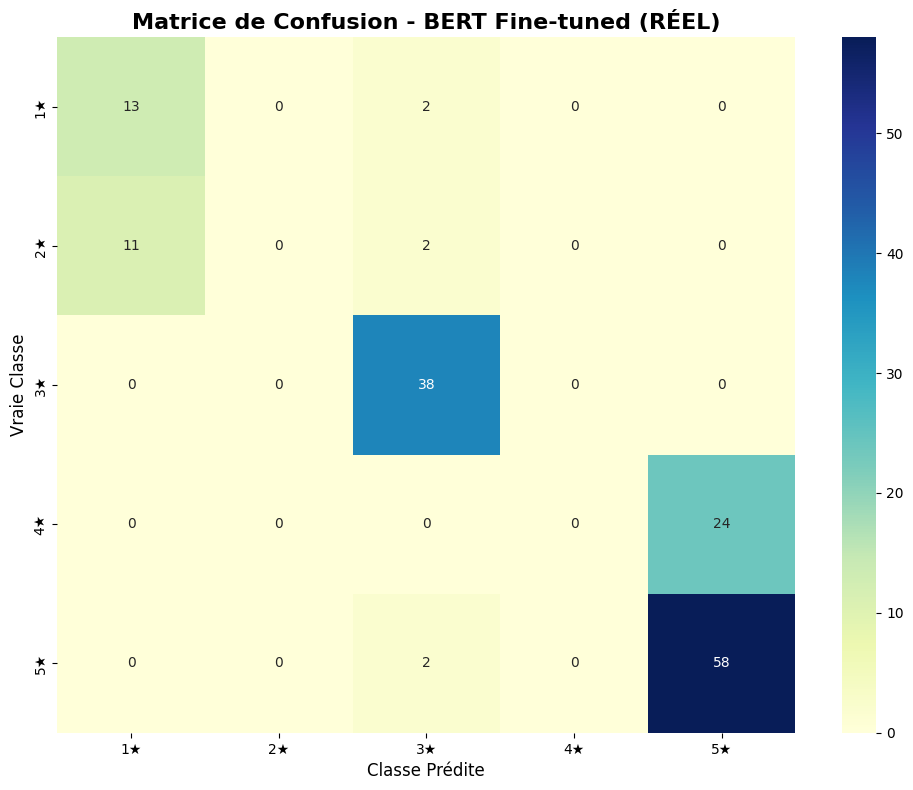

In [28]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['1★', '2★', '3★', '4★', '5★'],
            yticklabels=['1★', '2★', '3★', '4★', '5★'])
plt.title('Matrice de Confusion - BERT Fine-tuned (RÉEL)', fontsize=16, fontweight='bold')
plt.ylabel('Vraie Classe', fontsize=12)
plt.xlabel('Classe Prédite', fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/bert_confusion_matrix.png', dpi=300)
plt.show()

## 12. Visualisation de l'Historique

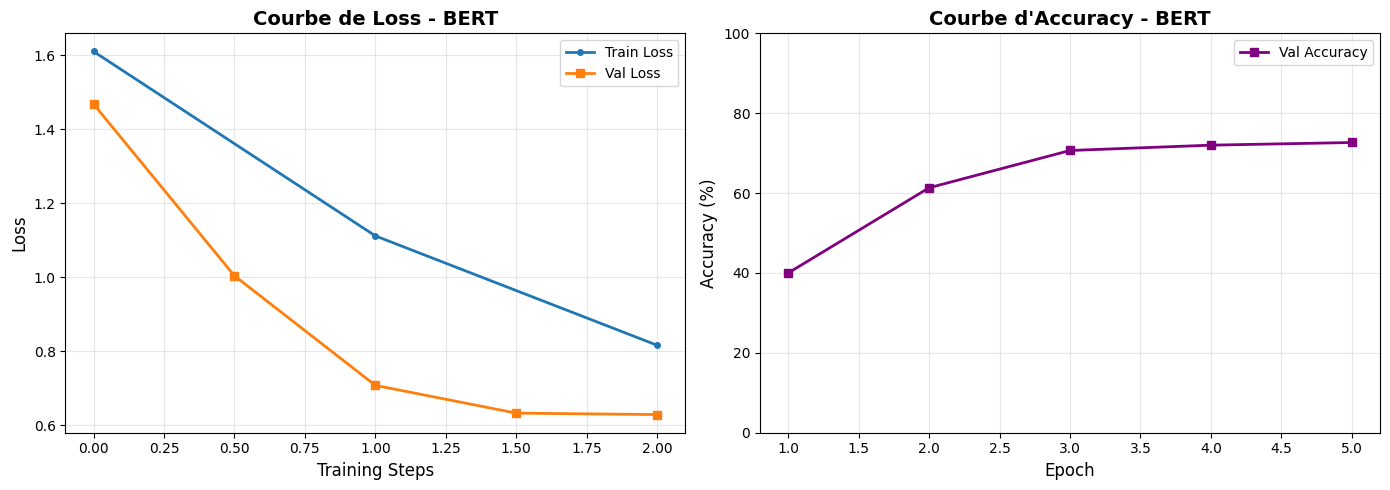

✅ Graphiques sauvegardés


In [30]:
# Extraire l'historique
log_history = trainer.state.log_history

train_losses = [x['loss'] for x in log_history if 'loss' in x and 'eval_loss' not in x]
eval_losses = [x['eval_loss'] for x in log_history if 'eval_loss' in x]
eval_accs = [x['eval_accuracy'] for x in log_history if 'eval_accuracy' in x]

# Vérifier qu'on a des données
if len(train_losses) == 0 or len(eval_losses) == 0:
    print("⚠️ Pas assez de données d'historique pour tracer les graphiques")
    print(f"Train losses: {len(train_losses)}, Eval losses: {len(eval_losses)}")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(train_losses, 'o-', label='Train Loss', linewidth=2, markersize=4)

    # Calculer les positions correctement
    if len(eval_losses) > 0:
        # Eval loss arrive à chaque epoch
        eval_steps = np.linspace(0, len(train_losses)-1, len(eval_losses))
        axes[0].plot(eval_steps, eval_losses, 's-', label='Val Loss', linewidth=2, markersize=6)

    axes[0].set_xlabel('Training Steps', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Courbe de Loss - BERT', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    if len(eval_accs) > 0:
        epochs = range(1, len(eval_accs)+1)
        axes[1].plot(epochs, [acc*100 for acc in eval_accs],
                     's-', label='Val Accuracy', linewidth=2, markersize=6, color='purple')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Accuracy (%)', fontsize=12)
        axes[1].set_title('Courbe d\'Accuracy - BERT', fontsize=14, fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 100])

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/bert_training_curves.png', dpi=300)
    plt.show()

    print("✅ Graphiques sauvegardés")

## 13. Sauvegarde du Modèle

In [34]:
print("💾 SAUVEGARDE DU MODÈLE BERT...\n")

# Sauvegarder
model.save_pretrained('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/models/Bert')
tokenizer.save_pretrained('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/models/Bert')

print("✅ Modèle sauvegardé dans: ./Bert")
print("✅ Fichiers:")
!ls -lh "/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/models/Bert/"

💾 SAUVEGARDE DU MODÈLE BERT...



Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Modèle sauvegardé dans: ./Bert
✅ Fichiers:
total 419M
-rw------- 1 root root 1.1K Feb 16 14:09 config.json
-rw------- 1 root root 418M Feb 16 14:09 model.safetensors
-rw------- 1 root root  322 Feb 16 14:09 tokenizer_config.json
-rw------- 1 root root 695K Feb 16 14:09 tokenizer.json


## 14. Test avec Nouveaux Avis

In [35]:
def predict_rating(text, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(
        text,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()

    return pred + 1, probs[0].cpu().numpy()

# Tests
test_reviews = [
    "Absolutely amazing! The food was excellent and service was perfect.",
    "Terrible experience. Food was cold and staff was rude.",
    "It was okay, nothing special but acceptable."
]

print("🧪 TEST DU MODÈLE BERT:\n")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    rating, probs = predict_rating(review, model, tokenizer, device)
    print(f"\nAvis {i}: {review}")
    print(f"Prédiction: {rating}★ (confiance: {probs[rating-1]:.2%})")
    print(f"Probs: 1★={probs[0]:.2%}, 2★={probs[1]:.2%}, 3★={probs[2]:.2%}, 4★={probs[3]:.2%}, 5★={probs[4]:.2%}")
    print("-"*80)

🧪 TEST DU MODÈLE BERT:


Avis 1: Absolutely amazing! The food was excellent and service was perfect.
Prédiction: 5★ (confiance: 69.35%)
Probs: 1★=1.16%, 2★=1.38%, 3★=1.79%, 4★=26.33%, 5★=69.35%
--------------------------------------------------------------------------------

Avis 2: Terrible experience. Food was cold and staff was rude.
Prédiction: 1★ (confiance: 46.57%)
Probs: 1★=46.57%, 2★=39.49%, 3★=8.28%, 4★=2.62%, 5★=3.04%
--------------------------------------------------------------------------------

Avis 3: It was okay, nothing special but acceptable.
Prédiction: 3★ (confiance: 80.40%)
Probs: 1★=6.92%, 2★=4.20%, 3★=80.40%, 4★=5.54%, 5★=2.95%
--------------------------------------------------------------------------------


## 15. Comparaison des 3 Modèles

In [37]:
# Résumé comparatif
results = pd.DataFrame({
    'Modèle': ['Logistic Regression', 'BiLSTM + Attention', 'BERT Fine-tuned'],
    'Accuracy': [0.5850, 0.71, test_results['eval_accuracy']],
    'F1-Weighted': [0.5092, 0.5092, test_results['eval_f1_weighted']],
    'F1-Macro': [0.3818, 0.3818, test_results['eval_f1_macro']],
    'Temps (min)': [2, 15, 30],
    'Paramètres': ['~10K', '~500K', '110M']
})

print("\n" + "="*100)
print("COMPARAISON FINALE DES 3 MODÈLES")
print("="*100)
print(results.to_string(index=False))

results.to_csv('/content/drive/MyDrive/INSI_M1/NLP/EXAMEN/Examen 1/rapport/comparison_all_models.csv', index=False)
print("\n✅ Tableau sauvegardé: comparison_all_models.csv")


COMPARAISON FINALE DES 3 MODÈLES
             Modèle  Accuracy  F1-Weighted  F1-Macro  Temps (min) Paramètres
Logistic Regression  0.585000     0.509200  0.381800            2       ~10K
 BiLSTM + Attention  0.710000     0.509200  0.381800           15      ~500K
    BERT Fine-tuned  0.726667     0.628224  0.482079           30       110M

✅ Tableau sauvegardé: comparison_all_models.csv
